## Load floodscan data and plot for SSD

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from rasterio.enums import Resampling
import matplotlib.colors as mcolors
import xarray as xr
import cftime
import math
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import matplotlib as mpl
import seaborn as sns
import glob

In [3]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[0]}/"
# print(path_mod)
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.utils_general.utils import download_ftp,download_url
from src.utils_general.raster_manipulation import fix_calendar, invert_latlon, change_longitude_range
from src.utils_general.plotting import plot_raster_boundaries_clip

#### Set config values

In [4]:
DATA_PRIVATE_DIR = os.path.join(os.environ["AA_DATA_PRIVATE_DIR"])

In [6]:
country="ssd"
config=Config()
parameters = config.parameters(country)

country_dir = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
country_data_raw_dir = os.path.join(config.DATA_DIR,config.RAW_DIR,country)
country_data_processed_dir = os.path.join(config.DATA_DIR,config.PROCESSED_DIR,country)
country_data_flooding_dir = os.path.join(country_data_processed_dir,"flooding")
country_data_chirps_daily_dir = os.path.join(country_data_flooding_dir,"gee_output")
country_data_exploration_dir = os.path.join(config.DATA_DIR,"exploration",country)
drought_data_exploration_dir= os.path.join(config.DATA_DIR, "exploration",  'drought')
cams_data_dir=os.path.join(drought_data_exploration_dir,"CAMS_OPI")
cams_tercile_path=os.path.join(cams_data_dir,"CAMS_tercile.nc")
chirps_monthly_dir=os.path.join(drought_data_exploration_dir,"CHIRPS")
chirps_monthly_path=os.path.join(chirps_monthly_dir,"chirps_global_monthly.nc")

In [7]:
adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

In [8]:
df_bound = gpd.read_file(adm1_bound_path)

In [14]:
floodscan_dir = os.path.join(DATA_PRIVATE_DIR,"floodscan-africa-1998-2020")
floodscan_path = os.path.join(floodscan_dir,"aer_sfed_area_300s_19980112-20201231_v05r01.nc")

In [15]:
ds=xr.open_dataset(floodscan_path)

In [16]:
ds

<xarray.Dataset>
Dimensions:        (lat: 1080, lon: 1080, time: 8390)
Coordinates:
  * time           (time) datetime64[ns] 1998-01-12 1998-01-13 ... 2020-12-31
  * lat            (lat) float64 39.96 39.87 39.79 ... -49.79 -49.88 -49.96
  * lon            (lon) float64 -29.96 -29.88 -29.79 ... 59.79 59.88 59.96
Data variables:
    crs            int8 ...
    SFED_AREA      (lat, lon, time) float32 ...
    NDT_SFED_AREA  (lat, lon, time) float32 ...
    LWMASK_AREA    (lat, lon) float32 ...

In [19]:
ds.sel(time="2020-08-01")

<xarray.Dataset>
Dimensions:        (lat: 1080, lon: 1080)
Coordinates:
    time           datetime64[ns] 2020-08-01
  * lat            (lat) float64 39.96 39.87 39.79 ... -49.79 -49.88 -49.96
  * lon            (lon) float64 -29.96 -29.88 -29.79 ... 59.79 59.88 59.96
Data variables:
    crs            int8 -127
    SFED_AREA      (lat, lon) float32 ...
    NDT_SFED_AREA  (lat, lon) float32 ...
    LWMASK_AREA    (lat, lon) float32 ...

In [22]:
#only select raster cells touching country
ds_clip = ds.rio.set_spatial_dims(x_dim="lon",y_dim="lat").rio.write_crs("EPSG:4326").rio.clip(df_bound.geometry.apply(mapping), df_bound.crs, all_touched=True)

In [35]:
#get date with max value
ds_clip.where(ds_clip.SFED_AREA==ds_clip.SFED_AREA.max(), drop=True).squeeze()

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    lat            float64 9.042
    lon            float64 32.71
    time           datetime64[ns] 2012-12-15
    crs            int64 0
Data variables:
    SFED_AREA      float32 0.9902
    NDT_SFED_AREA  float32 0.9904
    LWMASK_AREA    float32 0.0002
Attributes:
    grid_mapping:  crs

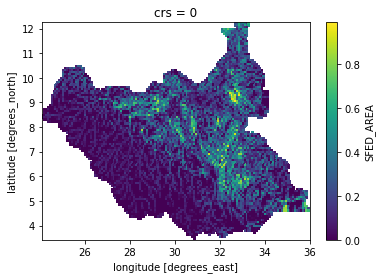

In [33]:
#plot date with max value
ds_clip.SFED_AREA.max("time").plot()

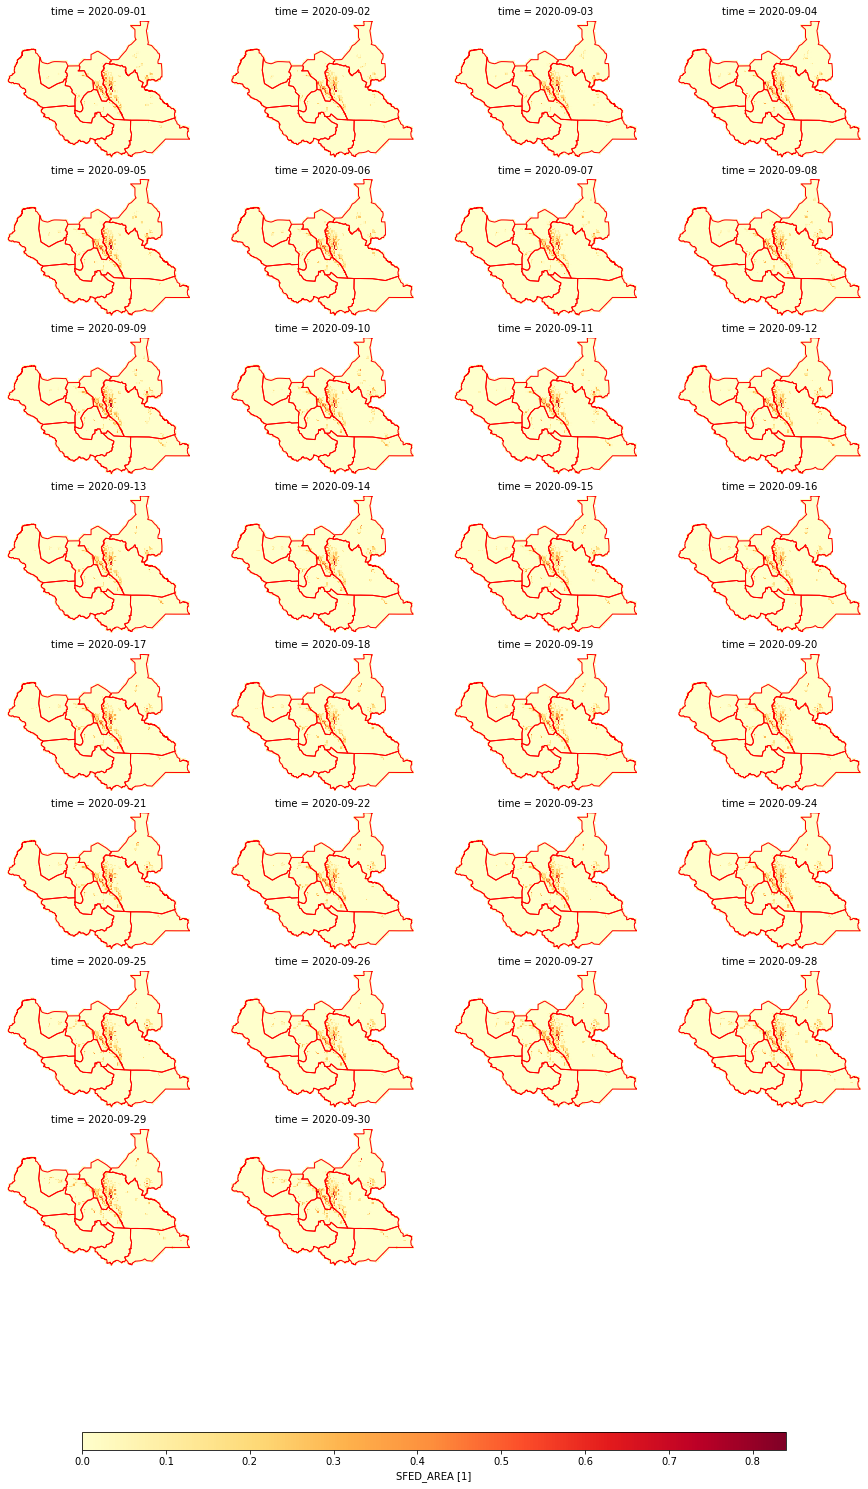

In [25]:
#plot random month
#inspired from https://xarray-contrib.github.io/xarray-tutorial/scipy-tutorial/04_plotting_and_visualization.html#facet
g=ds_clip.sel(time="2020-09").SFED_AREA.plot(
    col="time",
    col_wrap=4,
    cmap=mpl.cm.YlOrRd,
#     robust=True,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")

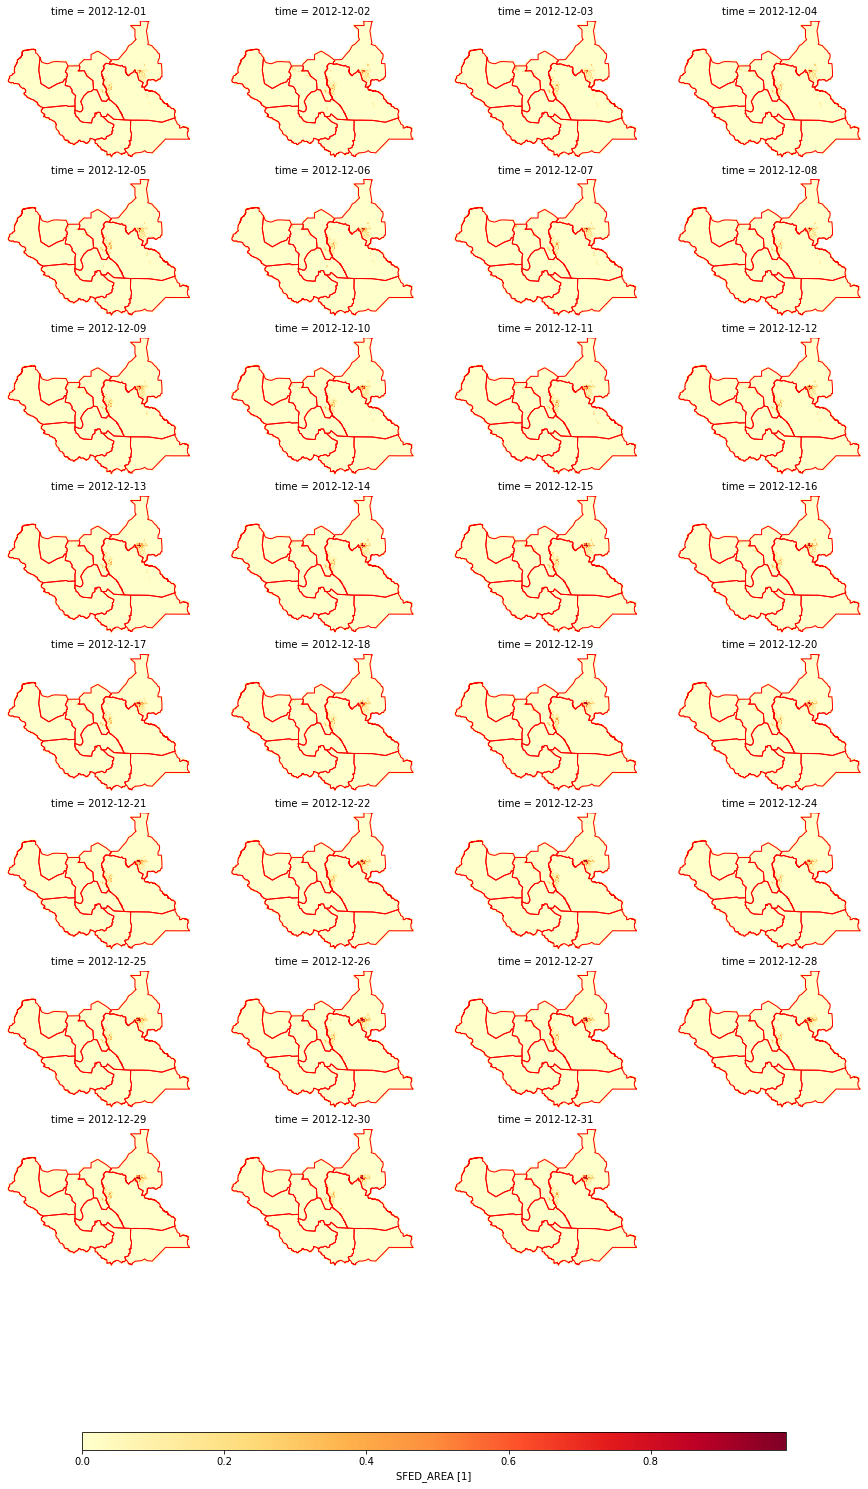

In [36]:
#plot month during which max value occurred
#inspired from https://xarray-contrib.github.io/xarray-tutorial/scipy-tutorial/04_plotting_and_visualization.html#facet
g=ds_clip.sel(time="2012-12").SFED_AREA.plot(
    col="time",
    col_wrap=4,
    cmap=mpl.cm.YlOrRd,
#     robust=True,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")